In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader ,random_split
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from zipfile import ZipFile
import os

In [22]:
path = os.path.join(os.getcwd(),"high_res_dataset.zip")
print(path)

c:\Users\osman\OneDrive\Documents\Python Projects\AI_Guild\emotion-classifier-baseline-main\high_res_dataset.zip


In [23]:

# # importing the zipfile module
# from zipfile import ZipFile
# import os
  
# # loading the temp.zip and creating a zip object
# with ZipFile(os.path.join(os.getcwd(),"high_res_dataset.zip"), 'r') as zObject:
  
#     # Extracting all the members of the zip 
#     # into a specific location.
#     zObject.extractall(
#         path=os.path.join(os.getcwd(),"high_res_dataset"))

In [24]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(256, 256))]) #, transforms.Grayscale()
img_data = datasets.ImageFolder(root=os.path.join(os.getcwd(), 'high_res_dataset'), transform=transform)


In [25]:
# from torch.utils.data import random_split, DataLoader
train_set, val_set = random_split(img_data, [25000, 6002])
dataloader_train = DataLoader(train_set, batch_size=32, shuffle=True)

dataloader_test = DataLoader(val_set, batch_size=32, shuffle=True)
print(img_data)
print(img_data.classes)

Dataset ImageFolder
    Number of datapoints: 31002
    Root location: c:\Users\osman\OneDrive\Documents\Python Projects\AI_Guild\emotion-classifier-baseline-main\high_res_dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
           )
['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [26]:
images, labels = next(iter(dataloader_train))
word_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

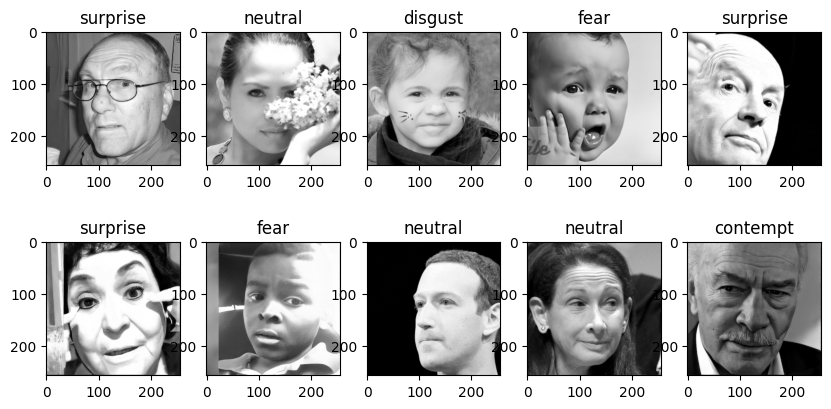

In [27]:
from matplotlib import image as mpimg
subplots = plt.subplots(2, 5, figsize=(10, 5))
# show the image
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].squeeze(),cmap="gray")
    plt.title(word_labels[labels[i]])


Configure the Device for gpu or cpu

In [28]:
#Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Setup Hyper parameters for the model

In [29]:
#Hyperparameters
num_epochs = 5 # amount of times the model will see the data
batch_size = 64 # amount of data to be processed at once
learning_rate = 0.001 # gradient descent step size

Load the data

In [30]:
print('Using device:', device)
# Print some basic information about the train and test datasets
print('Number of training examples: {}'.format(len(train_set)))
print('Number of test examples: {}'.format(len(val_set)))
# print('Batch size: {}'.format(batch_size))

# Print some basic information about the train and test loaders
print('Number of training batches: {}'.format(len(dataloader_train)))
print('Number of test batches: {}'.format(len(dataloader_test)))

# Check the range of the pixel values in the training images
# print("Minimum pixel value:", torch.min(train_set))
# print("Maximum pixel value:", torch.max(train_set))
# print(len(train_set))
images, _ = next(iter(train_set))
print("Minimum pixel value:", torch.min(images))
print("Maximum pixel value:", torch.max(images))


Using device: cuda
Number of training examples: 25000
Number of test examples: 6002
Number of training batches: 782
Number of test batches: 188
Minimum pixel value: tensor(0.0216)
Maximum pixel value: tensor(0.9980)


In [31]:
from efficientnet_pytorch import EfficientNet
class EfficientNet128(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNet128, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        num_ftrs = self.backbone._fc.in_features
        self.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.backbone.extract_features(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [32]:
def train(model: EfficientNet128, optimizer, loss_function,device,dataloader_train,epoch):
    model.train() # tells python that the model is training

    for idx, (images, labels) in enumerate(dataloader_train):
        images, labels = images.to(device), labels.to(device)
        # clear our gradients
        optimizer.zero_grad()
        # foward pass
        output = model.forward(images)
        # calculate loss
        loss = loss_function(output, labels)
        # calculate the gradients
        loss.backward() # just calculates the gradients
        optimizer.step() # updates the parameters
        if idx % 25 == 0:
            print(f"[epoch:{epoch}] loss = {loss}")

In [33]:
# # my test
# def test(model, device, dataloader_test):
#     model.eval() #tells torch we're evaluating (not training) the model
#     test_loss = 0 #store the test loss
#     correct = 0 #store the number of images the model got correct from the test set 
#     with torch.no_grad(): #important, otherwise torch will calculate the gradients for backpropagation. 
#         for data, target in dataloader_test: #iterate through each image in the test set
#             data, target = data.to(device), target.to(device)
#             output = model(data) #run the data through the model
#             test_loss += F.cross_entropy(output, target)  # sum up batch loss

#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the predicted class
#             #print(f"test pred: {pred.shape}") #32x1
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(dataloader_test.dataset)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(dataloader_test.dataset),
#         100. * correct / len(dataloader_test.dataset)))

In [34]:
# Jacob's test
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct_top1 = 0
    correct_top2 = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target)  # sum up batch loss

            _, predictions = torch.topk(input=output, k=2, dim=-1) # get the indices of the top classes

            top1 = predictions[:,0]
            top2 = predictions[:,1]
            correct_top1 += top1.eq(target.view_as(top1)).sum().item()
            correct_top2 += top2.eq(target.view_as(top2)).sum().item()

    top1_accuracy = 100.0 * correct_top1 / len(test_loader.dataset)
    top2_accuracy = 100.0 * (correct_top1 + correct_top2) / len(test_loader.dataset)
    #print(f"top-1 acc: {top1_accuracy:.3}%, top-2 acc: {top2_accuracy:.3}%")
    test_loss /= len(test_loader.dataset)
       

    #wandb.log({"test_acc_top1": top1_accuracy, "test_acc_top2": top2_accuracy, "test_loss": test_loss})

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Top-2 Accuracy: {:.0f}%\n'.format(
        test_loss, correct_top1, len(test_loader.dataset),
        top1_accuracy, top2_accuracy))

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNet128(len(img_data.classes)).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()
epochs = 1

for epoch in range(epochs):
    train(model=model, optimizer=optimizer, loss_function=loss_function, device=device,dataloader_train=dataloader_train,epoch=epoch)
    test(model=model, device=device, dataloader_test=dataloader_test)

Loaded pretrained weights for efficientnet-b0


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.38 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
test(model=model, device=device, test_loader=dataloader_test)


Test set: Average loss: 0.0303, Accuracy: 3876/6002 (65%), Top-2 Accuracy: 82%



In [ ]:
torch.save(model.state_dict(), 'model_params1.pth')